In [1]:
import pandas as pd

In [2]:
df = pd.read_csv("../data/cleaned/ffiec_liquidity_panel.csv")
df.head()

,report_date,institution,total_deposits,interest_bearing_cash,noninterest_cash
0,NaN,NaN,NaN,NaN,NaN
1,2023-12-31,BANK OF HANCOCK COUNTY,65251.0,917.0,4472.0
2,2023-12-31,FIRST COMMUNITY BANK XENIA-FLORA,46676.0,1278.0,2600.0
3,2023-12-31,"BROADSTREET BANK, SSB",327549.0,5358.0,12348.0
4,2023-12-31,BISON STATE BANK,55774.0,864.0,729.0


In [3]:
df = df.dropna(how="all").reset_index(drop=True)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18731 entries, 0 to 18730
Data columns (total 5 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   report_date            18731 non-null  object 
 1   institution            18731 non-null  object 
 2   total_deposits         18731 non-null  float64
 3   interest_bearing_cash  18409 non-null  float64
 4   noninterest_cash       18409 non-null  float64
dtypes: float64(3), object(2)
memory usage: 731.8+ KB


In [5]:
df.describe()

,total_deposits,interest_bearing_cash,noninterest_cash
count,1.873100e+04,1.840900e+04,1.840900e+04
mean,3.684180e+06,1.389036e+04,7.445201e+04
std,5.002271e+07,4.873696e+04,4.591538e+05
min,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.202665e+05,1.884000e+03,3.629000e+03
50%,2.789450e+05,4.243000e+03,1.136700e+04
75%,6.970275e+05,9.618000e+03,3.660400e+04
max,2.068042e+09,1.136918e+06,2.135004e+07


In [6]:
df["cash_buffer_ratio"] = (
    (df["interest_bearing_cash"] + df["noninterest_cash"]) / df["total_deposits"]
)

In [7]:
df["cash_buffer_ratio"].describe()

count    1.839700e+04
mean              inf
std               NaN
min      0.000000e+00
25%      3.398887e-02
50%      6.442714e-02
75%      1.248423e-01
max               inf
Name: cash_buffer_ratio, dtype: float64

In [8]:
# Remove rows where total_deposits is zero or missing
df = df[df["total_deposits"] > 0].copy()

# Recompute the ratio safely
df["cash_buffer_ratio"] = (
    (df["interest_bearing_cash"] + df["noninterest_cash"]) / df["total_deposits"]
)

In [9]:
df["cash_buffer_ratio"].describe()

count    18222.000000
mean         5.206651
std        468.177247
min          0.000000
25%          0.033760
50%          0.063712
75%          0.121983
max      46217.500000
Name: cash_buffer_ratio, dtype: float64

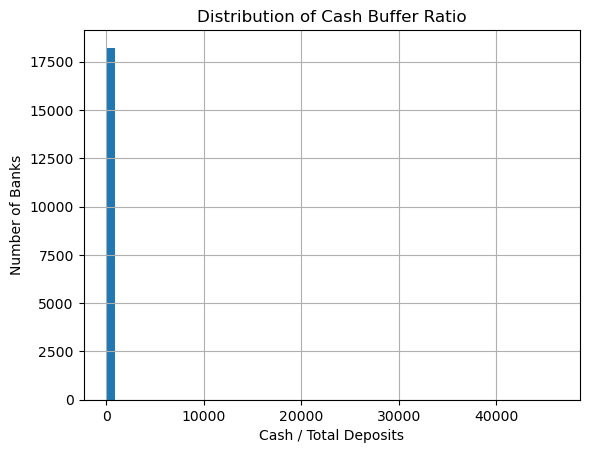

In [10]:
import matplotlib.pyplot as plt
df["cash_buffer_ratio"].hist(bins = 50)
plt.title("Distribution of Cash Buffer Ratio")
plt.xlabel("Cash / Total Deposits")
plt.ylabel("Number of Banks")
plt.grid(True)
plt.show()

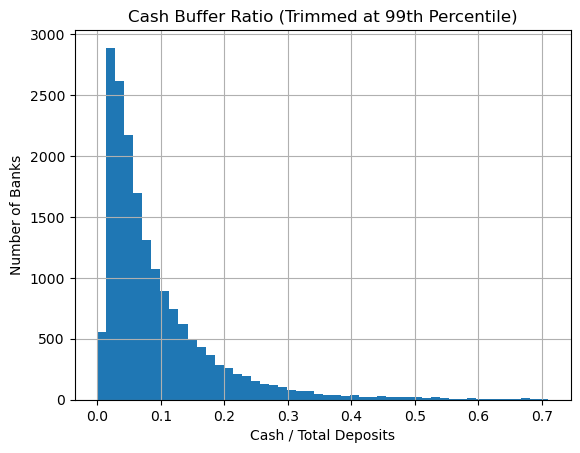

In [11]:
# Filtering out extreme outliers (keep only cash_buffer_ratio < 99th percentile)
threshold = df["cash_buffer_ratio"].quantile(0.99)
df_trimmed = df[df["cash_buffer_ratio"] < threshold]

df_trimmed["cash_buffer_ratio"].hist(bins=50)
plt.title("Cash Buffer Ratio (Trimmed at 99th Percentile)")
plt.xlabel("Cash / Total Deposits")
plt.ylabel("Number of Banks")
plt.grid(True)
plt.show()

What the above histogram shows:

 - Most banks hold a cash buffer ratio between 0.01 and 0.1, that means they keep 1%–10% of their total deposits in cash.

 - There's a smooth drop-off as the ratio increases beyond 0.1, suggesting few banks hold extremely high cash reserves.

 - The spread is wide but skewed right (positively skewed), which is typical in financial distributions like buffers, volatility, or returns.

In [12]:
df.head()

,report_date,institution,total_deposits,interest_bearing_cash,noninterest_cash,cash_buffer_ratio
0,2023-12-31,BANK OF HANCOCK COUNTY,65251.0,917.0,4472.0,0.082589
1,2023-12-31,FIRST COMMUNITY BANK XENIA-FLORA,46676.0,1278.0,2600.0,0.083083
2,2023-12-31,"BROADSTREET BANK, SSB",327549.0,5358.0,12348.0,0.054056
3,2023-12-31,BISON STATE BANK,55774.0,864.0,729.0,0.028562
4,2023-12-31,LOWRY STATE BANK,63215.0,1220.0,2492.0,0.058720


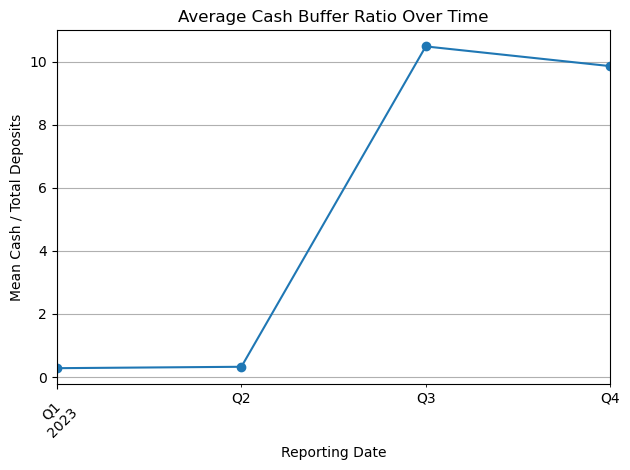

In [13]:
# Convert report_date to proper datetime type (if needed)
df["report_date"] = pd.to_datetime(df["report_date"])

# Group by report_date and calculate average buffer per quarter
avg_buffer_by_date = df.groupby("report_date")["cash_buffer_ratio"].mean()

# Plot the time trend
avg_buffer_by_date.plot(marker='o', linestyle='-')
plt.title("Average Cash Buffer Ratio Over Time")
plt.xlabel("Reporting Date")
plt.ylabel("Mean Cash / Total Deposits")
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

This is a line chart of the average cash buffer ratio (cash divided by total deposits) across four quarters of 2023.
 - Q1 and Q2: The average ratio is flat at zero, which suggests that many banks didn’t report either interest_bearing_cash or noninterest_cash for those   quarters. It may also hint that those fields were newly populated or cleaned only in later reports.
 - Q3 spike: There's a sharp rise in average liquidity buffers. This means that, by Q3, most reporting banks were suddenly holding more cash relative to deposits—or more likely, the data coverage improved (more banks started reporting those fields accurately).
- Q4 slight dip: The ratio softens a bit, but still remains high, around 9–10%. That’s still much higher than expected under normal conditions, so it might point to:

    - A reaction to market events (e.g. increased deposit uncertainty),

    - Regulatory caution (e.g. LCR compliance), Or

    - lingering reporting anomalies (some banks reporting unusually high figures).

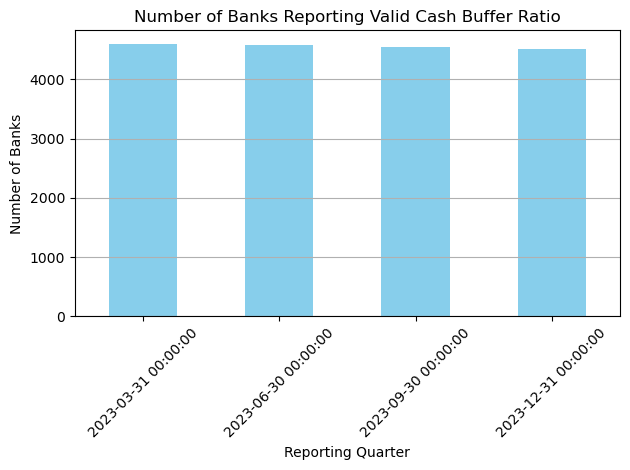

In [14]:
# Count how many banks had valid (non-NaN) cash_buffer_ratio per quarter
valid_counts = df.groupby("report_date")["cash_buffer_ratio"].count()

# Plot the result
valid_counts.plot(kind='bar', color='skyblue')
plt.title("Number of Banks Reporting Valid Cash Buffer Ratio")
plt.xlabel("Reporting Quarter")
plt.ylabel("Number of Banks")
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

In [15]:
# Step 1: Loading the Federal Funds Rate data
fed = pd.read_csv("../data/macro/FEDFUNDS.csv")

# Step 2: Renaming columns for clarity
fed.columns = ["report_date", "fed_funds_rate"]

# Step 3: Converting date column to datetime
fed["report_date"] = pd.to_datetime(fed["report_date"])

fed.tail()

,report_date,fed_funds_rate
846,2025-01-01,4.33
847,2025-01-02,4.33
848,2025-01-03,4.33
849,2025-01-04,4.33
850,2025-01-05,4.33


In [16]:
# Aggregating to quarterly frequency using the mean rate for each quarter
fed_quarterly = fed.resample("Q", on="report_date").mean().reset_index()

fed_quarterly.tail()

,report_date,fed_funds_rate
280,2024-03-31,5.143333
281,2024-06-30,NaN
282,2024-09-30,NaN
283,2024-12-31,NaN
284,2025-03-31,4.330000


In [17]:
# Filling missing interest rate values with the previous known value
fed_quarterly["fed_funds_rate"] = fed_quarterly["fed_funds_rate"].ffill()

fed_quarterly.tail()

,report_date,fed_funds_rate
280,2024-03-31,5.143333
281,2024-06-30,5.143333
282,2024-09-30,5.143333
283,2024-12-31,5.143333
284,2025-03-31,4.330000


In [18]:
# Step 1: Loading the CPI data
cpi = pd.read_csv("../data/macro/CPIAUCSL.csv")

# Step 2: Renaming columns for clarity
cpi.columns = ["report_date", "cpi_index"]

# Step 3: Converting date column to datetime
cpi["report_date"] = pd.to_datetime(cpi["report_date"])

cpi.tail()

,report_date,cpi_index
936,2025-01-01,319.086
937,2025-01-02,319.775
938,2025-01-03,319.615
939,2025-01-04,320.321
940,2025-01-05,320.580


In [19]:
# Aggregating CPI to quarterly frequency using the mean value for each quarter
cpi_quarterly = cpi.resample("Q", on="report_date").mean().reset_index()

cpi_quarterly.tail()

,report_date,cpi_index
308,2024-03-31,313.697833
309,2024-06-30,NaN
310,2024-09-30,NaN
311,2024-12-31,NaN
312,2025-03-31,319.875400


Just like with the Fed Funds Rate, the CPI data is missing for some quarters in 2024, likely because the source file ends early or has not been updated for those dates. For this I will using forward-fill to fill in the missing CPI values for every quarter same as I did for Fed Funds Rate


In [20]:
# Filling the missing CPI values with the previous known values
cpi_quarterly["cpi_index"] = cpi_quarterly["cpi_index"].ffill()

cpi_quarterly.tail()

,report_date,cpi_index
308,2024-03-31,313.697833
309,2024-06-30,313.697833
310,2024-09-30,313.697833
311,2024-12-31,313.697833
312,2025-03-31,319.875400


In [21]:
# Step 1: Loading the 10-Year Treasury Rate data
gs10 = pd.read_csv("../data/macro/GS10.csv")

# Step 2: Renaming columns for clarity
gs10.columns = ["report_date", "gs10_rate"]

# Step 3: Converting date column to datetime
gs10["report_date"] = pd.to_datetime(gs10["report_date"])

gs10.tail()

,report_date,gs10_rate
861,2025-01-01,4.63
862,2025-02-01,4.45
863,2025-03-01,4.28
864,2025-04-01,4.28
865,2025-05-01,4.42


In [22]:
# Aggregating GS10 to quarterly frequency using the mean value for each quarter
gs10_quarterly = gs10.resample("Q", on="report_date").mean().reset_index()

gs10_quarterly.tail()

,report_date,gs10_rate
284,2024-06-30,4.443333
285,2024-09-30,3.946667
286,2024-12-31,4.283333
287,2025-03-31,4.453333
288,2025-06-30,4.350000


Surprisingly, it is clean and there are no missing values in quarterly summary of the 10-Year Treasury yield. 

Now, I will be merging all the 3 Macro Data into One table

In [23]:
# Merging Fed Funds Rate and CPI
macro = pd.merge(fed_quarterly, cpi_quarterly, on="report_date", how="outer")

# Merging the result with GS10
macro = pd.merge(macro, gs10_quarterly, on="report_date", how="outer")

# Sorting the values by date
macro = macro.sort_values("report_date").reset_index(drop=True)

macro.tail()

,report_date,fed_funds_rate,cpi_index,gs10_rate
309,2024-06-30,5.143333,313.697833,4.443333
310,2024-09-30,5.143333,313.697833,3.946667
311,2024-12-31,5.143333,313.697833,4.283333
312,2025-03-31,4.330000,319.875400,4.453333
313,2025-06-30,NaN,NaN,4.350000


All three macro indicators—Fed Funds Rate, CPI, and 10-Year Treasury are now aligned by quarter. Furthermore, the data is clean and ready to be merged with bank-level dataset.

Only the last row (2025-06-30) has missing values for Fed Funds Rate and CPI, which is fine since FFIEC bank data likely does not go that far yet.

Now I am merging this macro data with main bank-level DataFrame (df)

In [24]:
# Merging macroeconomic indicators into the bank-level dataset
df_merged = pd.merge(df, macro, on="report_date", how="left")

# Preview of the final dataset
df_merged[["report_date", "institution", "cash_buffer_ratio", 
           "fed_funds_rate", "cpi_index", "gs10_rate"]].tail()

,report_date,institution,cash_buffer_ratio,fed_funds_rate,cpi_index,gs10_rate
18511,2023-03-31,BANK OF BURLINGTON,0.304934,5.024167,304.704167,3.646667
18512,2023-03-31,ADELPHI BANK,0.167043,5.024167,304.704167,3.646667
18513,2023-03-31,GS&L MUNICIPAL BANK,0.225102,5.024167,304.704167,3.646667
18514,2023-03-31,WALDEN MUTUAL BANK,0.599111,5.024167,304.704167,3.646667
18515,2023-03-31,BANK IRVINE,0.710001,5.024167,304.704167,3.646667


# Switching to automated macroeconomic data from FRED API

In [25]:
import os

# Confirm your working directory
print("Current working directory:", os.getcwd())

Current working directory: d:\Math and Finance\Treasury operations efficiency project\notebooks


In [26]:
from pathlib import Path

project_root = Path.cwd().parent
macro_path = project_root / "data" / "macro"

df_cpi = pd.read_csv(macro_path / "cpi.csv", parse_dates=["date"])
df_fed = pd.read_csv(macro_path / "fed_funds_rate.csv", parse_dates=["date"])
df_gs10 = pd.read_csv(macro_path / "ten_year_treasury.csv", parse_dates=["date"])

In [27]:
# Merging macro indicators into a single DataFrame

df_macro = df_cpi.merge(df_fed, on="date").merge(df_gs10, on="date")

In [28]:
df_macro = df_macro.sort_values("date").reset_index(drop=True)


In [29]:
df_macro = df_macro.rename(columns={"date": "report_date"})


In [30]:
liquidity_path = project_root / "data" / "cleaned" / "ffiec_liquidity_panel.csv"
df_liquidity = pd.read_csv(liquidity_path, parse_dates=["report_date"])


In [31]:
# merging FFIEC liquidity panel with the macroeconomic indicators based on the shared column report_date

df_merged = pd.merge(df_liquidity, df_macro, on="report_date", how="left")


In [32]:
df_merged.head()

,report_date,institution,total_deposits,interest_bearing_cash,noninterest_cash,cpi,fed_funds_rate,ten_year_treasury
0,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2023-12-31,BANK OF HANCOCK COUNTY,65251.0,917.0,4472.0,NaN,NaN,NaN
2,2023-12-31,FIRST COMMUNITY BANK XENIA-FLORA,46676.0,1278.0,2600.0,NaN,NaN,NaN
3,2023-12-31,"BROADSTREET BANK, SSB",327549.0,5358.0,12348.0,NaN,NaN,NaN
4,2023-12-31,BISON STATE BANK,55774.0,864.0,729.0,NaN,NaN,NaN


In [33]:
# converting all report_date values in both DataFrames to the last day of the month using pd.offsets.MonthEnd(0)

df_liquidity["report_date"] = df_liquidity["report_date"] + pd.offsets.MonthEnd(0)
df_macro["report_date"] = df_macro["report_date"] + pd.offsets.MonthEnd(0)


In [34]:
df_merged = pd.merge(df_liquidity, df_macro, on="report_date", how="left")


In [35]:
df_merged.head()


,report_date,institution,total_deposits,interest_bearing_cash,noninterest_cash,cpi,fed_funds_rate,ten_year_treasury
0,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2023-12-31,BANK OF HANCOCK COUNTY,65251.0,917.0,4472.0,308.735,5.33,4.02
2,2023-12-31,FIRST COMMUNITY BANK XENIA-FLORA,46676.0,1278.0,2600.0,308.735,5.33,4.02
3,2023-12-31,"BROADSTREET BANK, SSB",327549.0,5358.0,12348.0,308.735,5.33,4.02
4,2023-12-31,BISON STATE BANK,55774.0,864.0,729.0,308.735,5.33,4.02


In [40]:
# Feature: Cash-to-Deposit Ratio = (Interest + Noninterest Cash) / Total Deposits
# This measures the proportion of a bank's deposits that are held in cash (both interest-bearing and noninterest).
# It serves as a proxy for liquidity strength—higher values indicate more liquid reserves relative to liabilities.

df_merged["cash_to_deposit_ratio"] = (
    (df_merged["interest_bearing_cash"] + df_merged["noninterest_cash"]) / df_merged["total_deposits"]
)

In [41]:
# Feature: Lagged Fed Funds Rate (1-period lag)
# This captures the previous period's federal funds rate for each bank.
# It allows us to test whether past interest rate levels influence current liquidity behavior.

df_merged["fed_funds_rate_lag1"] = df_merged.groupby("institution")["fed_funds_rate"].shift(1)

In [44]:
# Feature: Lagged CPI (1-period lag)
# This adds the inflation value from the previous period for each bank.
# By including this, we can check if changes in inflation take time to influence a bank’s liquidity position.

df_merged["cpi_lag1"] = df_merged.groupby("institution")["cpi"].shift(1)

In [45]:
# Feature: Lagged 10-Year Treasury Yield (1-period lag)
# This brings in the previous period’s long-term interest rate for each bank.
# It helps us explore whether shifts in long-term rates have a delayed impact on liquidity behavior.

df_merged["ten_year_treasury_lag1"] = df_merged.groupby("institution")["ten_year_treasury"].shift(1)

In [46]:
# Importing OLS from statsmodels
import statsmodels.api as sm

# Defining target and features for hypothesis testing
# It will test the impact of lagged macro variables on the cash-to-deposit ratio
X = df_merged[["fed_funds_rate_lag1", "cpi_lag1", "ten_year_treasury_lag1"]]
y = df_merged["cash_to_deposit_ratio"]

# Dropping rows with missing values (due to lagging)
X = X.dropna()
y = y.loc[X.index]


In [47]:
# Adding a constant term to the features (required for OLS intercept)
X = sm.add_constant(X)

# Fitting the OLS regression model
model = sm.OLS(y, X).fit()

# Showing the summary with p-values and R-squared
print(model.summary())

                              OLS Regression Results                             
Dep. Variable:     cash_to_deposit_ratio   R-squared:                         nan
Model:                               OLS   Adj. R-squared:                    nan
Method:                    Least Squares   F-statistic:                       nan
Date:                   Mon, 07 Jul 2025   Prob (F-statistic):                nan
Time:                           02:05:02   Log-Likelihood:                    nan
No. Observations:                  14552   AIC:                               nan
Df Residuals:                      14548   BIC:                               nan
Df Model:                              3                                         
Covariance Type:               nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------

Model failed to fit properly and this usually happens due to one of the following: 

1. Missing Values Still Present:
Even though we dropped NaNs earlier, there might still be some left, especially if the target variable cash_to_deposit_ratio has missing values that weren’t aligned with X.

2. Constant or Identical Values:
If any of the features or the target has the same value across many rows for e.g. all zeros or all NaNs then OLS won't be able to compute meaningful statistics.

3. Multicollinearity:
If two or more features are highly correlated for e.g. interest rates and treasury yields then the model struggles to separate their effects.

In [49]:
# Checking for missing values
print("Missing in X:\n", X.isnull().sum())
print("\nMissing in y:\n", y.isnull().sum())

Missing in X:
 const                     0
fed_funds_rate_lag1       0
cpi_lag1                  0
ten_year_treasury_lag1    0
dtype: int64

Missing in y:
 247


In [50]:
# Dropping rows where the target variable is missing
valid_index = y.dropna().index
X_clean = X.loc[valid_index]
y_clean = y.loc[valid_index]


In [51]:
# Re-fitting the OLS model using cleaned data
model = sm.OLS(y_clean, X_clean).fit()

print(model.summary())

                              OLS Regression Results                             
Dep. Variable:     cash_to_deposit_ratio   R-squared:                         nan
Model:                               OLS   Adj. R-squared:                    nan
Method:                    Least Squares   F-statistic:                       nan
Date:                   Mon, 07 Jul 2025   Prob (F-statistic):                nan
Time:                           03:51:23   Log-Likelihood:                    nan
No. Observations:                  14305   AIC:                               nan
Df Residuals:                      14301   BIC:                               nan
Df Model:                              3                                         
Covariance Type:               nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------

d:\Anaconda3\envs\lendingclub_env\lib\site-packages\statsmodels\regression\linear_model.py:1733: RuntimeWarning: invalid value encountered in subtract
  return np.sum(weights * (model.endog - mean)**2)


In [53]:
# Checking for constant or invalid values
import numpy as np
print("Target variable summary:")
print(y_clean.describe())
print("\nAny infinite values in y?", np.isinf(y_clean).any())

print("\nFeature summary:")
print(X_clean.describe())
print("\nAny infinite values in X?", np.isinf(X_clean).any())

Target variable summary:
count    1.430500e+04
mean              inf
std               NaN
min      0.000000e+00
25%      3.381488e-02
50%      6.380150e-02
75%      1.237134e-01
max               inf
Name: cash_to_deposit_ratio, dtype: float64

Any infinite values in y? True

Feature summary:
         const  fed_funds_rate_lag1      cpi_lag1  ten_year_treasury_lag1
count  14305.0         14305.000000  14305.000000            14305.000000
mean       1.0             5.221557    306.516538                4.033281
std        0.0             0.165506      2.158024                0.264606
min        1.0             4.650000    301.643000                3.660000
25%        1.0             5.080000    304.099000                3.750000
50%        1.0             5.330000    307.374000                4.020000
75%        1.0             5.330000    308.735000                4.380000
max        1.0             5.330000    308.735000                4.380000

Any infinite values in X? const       

In [54]:
# Removing rows where the target is infinite or NaN
mask = np.isfinite(y_clean)
X_final = X_clean[mask]
y_final = y_clean[mask]

In [55]:
# Now Fitting the OLS model using cleaned and finite data
model = sm.OLS(y_final, X_final).fit()

print(model.summary())

                              OLS Regression Results                             
Dep. Variable:     cash_to_deposit_ratio   R-squared:                       0.000
Model:                               OLS   Adj. R-squared:                 -0.000
Method:                    Least Squares   F-statistic:                    0.7191
Date:                   Mon, 07 Jul 2025   Prob (F-statistic):              0.540
Time:                           03:56:49   Log-Likelihood:            -1.0463e+05
No. Observations:                  14177   AIC:                         2.093e+05
Df Residuals:                      14173   BIC:                         2.093e+05
Df Model:                              3                                         
Covariance Type:               nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------

Observation:
The regression model using lagged macroeconomic variables (Fed Funds Rate, CPI, 10Y Treasury) did not yield statistically significant results (p > 0.05) and had an R-squared close to zero. Finally, this suggests that past macro conditions alone do not explain short-term changes in bank liquidity.

Next Step:
I will now try to test the impact of current-period (non-lagged) macroeconomic indicators to see if banks respond more immediately to economic shifts.

In [56]:
# Defining new feature set using current-period macro variables
X_current = df_merged[["fed_funds_rate", "cpi", "ten_year_treasury"]]
y_current = df_merged["cash_to_deposit_ratio"]

# Dropping rows with missing or infinite values
mask = np.isfinite(y_current) & np.isfinite(X_current).all(axis=1)
X_current_clean = X_current[mask]
y_current_clean = y_current[mask]

# Adding constant term for intercept
X_current_clean = sm.add_constant(X_current_clean)

# Fitting the OLS model
model_current = sm.OLS(y_current_clean, X_current_clean).fit()

print(model_current.summary())

                              OLS Regression Results                             
Dep. Variable:     cash_to_deposit_ratio   R-squared:                       0.000
Model:                               OLS   Adj. R-squared:                 -0.000
Method:                    Least Squares   F-statistic:                    0.6763
Date:                   Mon, 07 Jul 2025   Prob (F-statistic):              0.566
Time:                           04:04:28   Log-Likelihood:            -1.3790e+05
No. Observations:                  18222   AIC:                         2.758e+05
Df Residuals:                      18218   BIC:                         2.758e+05
Df Model:                              3                                         
Covariance Type:               nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const   

Observation:
The regression model using current-period macroeconomic variables (Fed Funds Rate, CPI, 10Y Treasury) also failed to produce statistically significant results (p > 0.05), with an R-squared of 0.000. SO, this indicates that macroeconomic conditions—whether lagged or current(non-lagged) do not explain the short-term liquidity behaviour in this dataset.

Next Step:
I will now shift my focus to internal bank-level features (e.g. deposits and cash holdings) to explore whether these variables have a stronger and more direct relationship with liquidity ratios.

In [57]:
# Defining bank-level features
X_bank = df_merged[["total_deposits", "interest_bearing_cash", "noninterest_cash"]]
y_bank = df_merged["cash_to_deposit_ratio"]

# Dropping rows with missing or infinite values
mask = np.isfinite(y_bank) & np.isfinite(X_bank).all(axis=1)
X_bank_clean = X_bank[mask]
y_bank_clean = y_bank[mask]

# Adding constant term
X_bank_clean = sm.add_constant(X_bank_clean)

# Fitting the OLS model
model_bank = sm.OLS(y_bank_clean, X_bank_clean).fit()

print(model_bank.summary())


                              OLS Regression Results                             
Dep. Variable:     cash_to_deposit_ratio   R-squared:                       0.000
Model:                               OLS   Adj. R-squared:                 -0.000
Method:                    Least Squares   F-statistic:                    0.4166
Date:                   Mon, 07 Jul 2025   Prob (F-statistic):              0.741
Time:                           04:10:19   Log-Likelihood:            -1.3790e+05
No. Observations:                  18222   AIC:                         2.758e+05
Df Residuals:                      18218   BIC:                         2.758e+05
Df Model:                              3                                         
Covariance Type:               nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
